In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from IPython.display import HTML
import base64
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import re

import seaborn as sns
color = sns.color_palette()

from dataclasses import dataclass
import itertools
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import math

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [3]:
df_org = pd.read_csv('updated_2year.csv')
df_org

net profit / total assets total liabilities / total assets  \
0                       0.20235                            0.465   
1                      0.030073                          0.59563   
2                       0.25786                          0.29949   
3                       0.22716                           0.6785   
4                      0.085443                          0.38039   
...                         ...                              ...   
10168                   0.02997                          0.66806   
10169                  0.012843                          0.49306   
10170                  0.015092                          0.55759   
10171                 -0.002554                          0.47076   
10172                  0.002072                          0.94315   

      working capital / total assets current assets / short-term liabilities  \
0                            0.24038                                  1.5171   
1                            0.18668                                  1.3382   
2                            0.66519                                  3.2211   
3                           0.042784                                  1.0828   
4                            0.35923                                  1.9444   
...                              ...                                     ...   
10168                       0.066243                                  1.1103   
10169                       -0.16062                                 0.61898   
10170                        -0.2846                                 0.48599   
10171                        0.42401                                  1.9007   
10172                       -0.13474                                 0.85607   

      [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365  \
0                                                -14.547                                                                    
1                                                -37.859                                                                    
2                                                 71.799                                                                    
3                                                -88.212                                                                    
4                                                 21.731                                                                    
...                                                  ...                                                                    
10168                                            -105.55                                                                    
10169                                            -24.801                                                                    
10170                                            -85.571                                                                    
10171                                            0.95483                                                                    
10172                                            -119.92                                                                    

      retained earnings / total assets EBIT / total assets  \
0                              0.51069             0.25366   
1                          -0.00031864             0.04167   
2                                    0             0.31877   
3                                    0             0.28505   
4                               0.1879             0.10823   
...                                ...                 ...   
10168                          0.02997            0.038888   
10169                         0.012843            0.012843   
10170                         0.015092            0.009826   
10171                        -0.002554            0.001785   
10172                         0.015226       

In [4]:
df_org['Target'].value_counts(bool)

0    0.96068
1    0.03932
Name: Target, dtype: float64

### Preprocessing

In [5]:
## replace '?' with None
for x in df_org.columns:
    df_org[x] = df_org[x].replace('?',None)

In [6]:
df = df_org.copy()

In [7]:
for x in df.columns:
    df[x] = df[x].astype(float)

In [8]:
for x in df.columns:
    perc = round((df[df[x].isnull()].shape[0]/10173)*100,2)
#     print(perc)
    if perc <3:
        print(x, perc)
        df = df[df[x].notnull()]

net profit / total assets 0.01
total liabilities / total assets 0.0
working capital / total assets 0.0
current assets / short-term liabilities 0.22
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365 0.21
retained earnings / total assets 0.0
EBIT / total assets 0.0
book value of equity / total liabilities 0.01
sales / total assets 0.01
equity / total assets 0.0
(gross profit + extraordinary items + financial expenses) / total assets 0.0
gross profit / short-term liabilities 0.0
(gross profit + depreciation) / sales 0.49
(gross profit + interest) / total assets 0.0
(total liabilities * 365) / (gross profit + depreciation) 0.01
(gross profit + depreciation) / total liabilities 0.0
total assets / total liabilities 0.0
gross profit / total assets 0.0
gross profit / sales 0.01
(inventory * 365) / sales 0.0
profit on operating activities / total assets 0.0
net profit / sales 0.0
gross profit (in 3 years) / total assets 2.16
(equ

In [9]:
for x in df.columns:
    perc = round((df[df[x].isnull()].shape[0]/10173)*100,2)
    if perc >3:
        print(x, perc)

sales (n) / sales (n-1) 26.46
profit on operating activities / financial expenses 5.16
(current assets - inventories) / long-term liabilities 39.63
net profit / inventory 3.88
sales / inventory 3.9


In [10]:
import plotly.express as px

null_values_columns = ['sales (n) / sales (n-1)', 'profit on operating activities / financial expenses', '(current assets - inventories) / long-term liabilities', 'net profit / inventory','sales / inventory']

temp_df = df[null_values_columns]
fig = px.box(temp_df, width = 1600, height = 600)
fig.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=14,  # Set the font size here
        color="Black"
    )
)
fig.show()

In [11]:
## Replace null values with median above columns have outliers
for col in null_values_columns:
    df[col] = df[col].fillna(df[col].median())
    df[col] = df[col].astype(float)    

#### Standardize

In [12]:
df.iloc[:,:-1]=(df.iloc[:,:-1]-df.iloc[:,:-1].mean())/df.iloc[:,:-1].std()

In [13]:
df.describe()

net profit / total assets  total liabilities / total assets  \
count               9.450000e+03                      9.450000e+03   
mean                9.022765e-18                     -1.759439e-16   
std                 1.000000e+00                      1.000000e+00   
min                -3.078396e+01                     -1.273998e+00   
25%                -2.857556e-01                     -5.962536e-01   
50%                -6.799693e-02                     -9.292731e-02   
75%                 3.364935e-01                      4.197229e-01   
max                 1.362271e+01                      3.381847e+01   

       working capital / total assets  \
count                    9.450000e+03   
mean                     3.609106e-17   
std                      1.000000e+00   
min                     -3.645110e+01   
25%                     -4.070176e-01   
50%                      1.847592e-02   
75%                      5.229806e-01   
max                      2.028233e+00   

       current assets / short-term liabilities  \
count                             9.450000e+03   
mean                             -2.180502e-17   
std                               1.000000e+00   
min                              -2.301335e-01   
25%                              -1.551768e-01   
50%                              -1.199739e-01   
75%                              -3.374153e-02   
max                               5.725913e+01   

       [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365  \
count                                       9.450000e+03                                                                     
mean                                       -2.631640e-18                                                                     
std                                         1.000000e+00                                                                     
min                                        -7.449655e+01                                                                     
25%                                         3.942008e-03                                                                     
50%                                         1.206336e-02                                                                     
75%                                         2.086837e-02                                                                     
max                                         1.203028e+01                                                                     

       retained earnings / total assets  EBIT / total assets  \
count                      9.450000e+03         9.450000e+03   
mean                       3.007588e-18         7.518971e-19   
std                        1.000000e+00         1.000000e+00   
min                       -3.322842e+01        -1.042148e+00   
25%                       -4.704913e-02        -2.184443e-02   
50%                       -4.704913e-02        -1.322909e-02   
75%                        1.461368e-01         2.338143e-03   
max                        3.218628e+01         9.713947e+01   

       book value of equity / total liabilities  sales / total assets  \
count                              9.450000e+03          9.450000e+03   
mean                              -5.263280e-18         -7.330996e-18   
std                                1.000000e+00          1.000000e+00   
min                               -1.841417e-01         -2.834905e-02   
25%                               -1.129962e-01         -1.809174e-02   
50%                               -9.167431e-02         -1.580828e-02   
75%                               -3.860777e-02         -6.318678e-03   
max                                5.686227e+01          9.719079e+01   

       equity / total assets  \
count           9.450000e+03   
mean            7.518971e-17   
std             1.000000e+00   
min            -3.374248e+01   
25%            -4.189710e

#### Linearly dependent columns

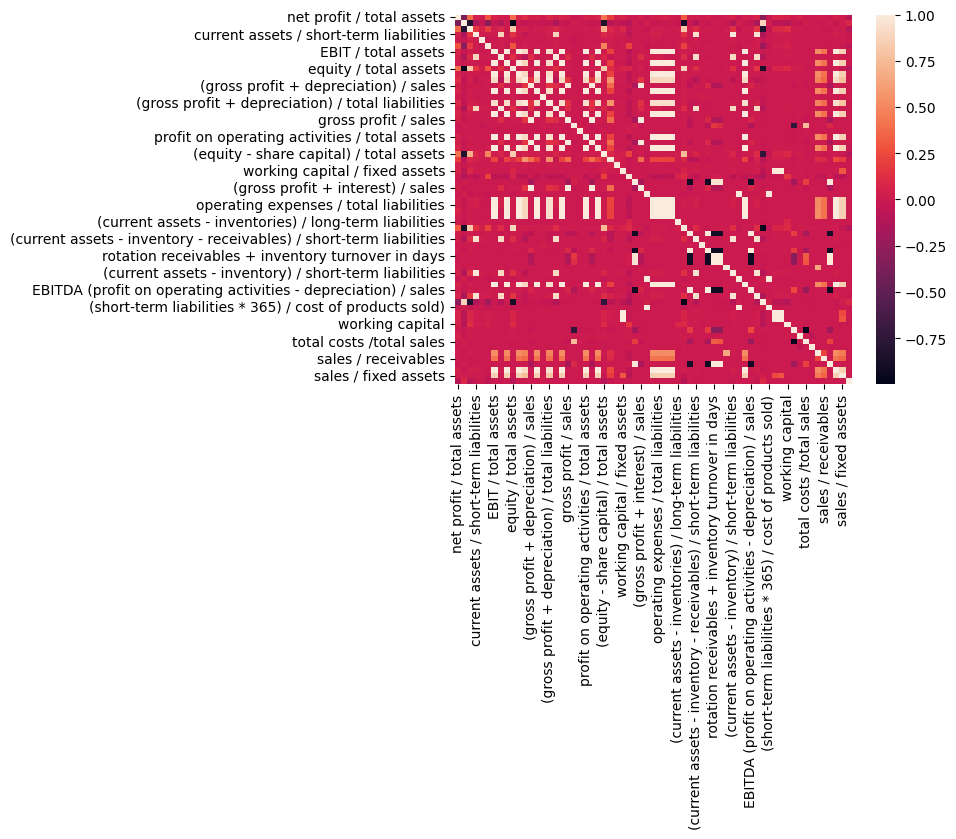

In [14]:
sns.heatmap(df.corr());

In [15]:
def corrank(matrix):        
    return pd.DataFrame([[(i,j),matrix.loc[i,j]] for i,j in list(itertools.combinations(matrix, 2))], columns=['pairs','corr'])

In [16]:
corr_matrix_filtered = df.corr()
corr_matrix_filtered = corrank(corr_matrix_filtered)
corr_matrix_filtered = corr_matrix_filtered.sort_values(by='corr',ascending=False)

In [17]:
corr_matrix = df.corr().abs()

In [18]:
upper =  np.array(np.triu(np.ones(corr_matrix.shape), k=1), dtype=bool)
upper = corr_matrix.where(upper)
upper

net profit / total assets  \
net profit / total assets                                                 NaN   
total liabilities / total assets                                          NaN   
working capital / total assets                                            NaN   
current assets / short-term liabilities                                   NaN   
[(cash + short-term securities + receivables - ...                        NaN   
...                                                                       ...   
sales / receivables                                                       NaN   
(short-term liabilities *365) / sales                                     NaN   
sales / short-term liabilities                                            NaN   
sales / fixed assets                                                      NaN   
Target                                                                    NaN   

                                                    total liabilities / total assets  \
net profit / total assets                                                   0.379037   
total liabilities / total assets                                                 NaN   
working capital / total assets                                                   NaN   
current assets / short-term liabilities                                          NaN   
[(cash + short-term securities + receivables - ...                               NaN   
...                                                                              ...   
sales / receivables                                                              NaN   
(short-term liabilities *365) / sales                                            NaN   
sales / short-term liabilities                                                   NaN   
sales / fixed assets                                                             NaN   
Target                                                                           NaN   

                                                    working capital / total assets  \
net profit / total assets                                                 0.378809   
total liabilities / total assets                                          0.804572   
working capital / total assets                                                 NaN   
current assets / short-term liabilities                                        NaN   
[(cash + short-term securities + receivables - ...                             NaN   
...                                                                            ...   
sales / receivables                                                            NaN   
(short-term liabilities *365) / sales                                          NaN   
sales / short-term liabilities                                                 NaN   
sales / fixed assets                                                           NaN   
Target                                                                         NaN   

                                                    current assets / short-term liabilities  \
net profit / total assets                                                          0.050519   
total liabilities / total assets                                                   0.142325   
working capital / total assets                                                     0.160542   
current assets / short-term liabilities                                                 NaN   
[(cash + short-term securities + receivables - ...                                      NaN   
...                                                                                     ...   
sales / receivables                                                                     NaN   
(short-term liabilities *365) / sales                                                   NaN   
sales / short-term liabilities                                                          NaN   
sales / fixed assets                   

In [19]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
len(to_drop)

39

In [20]:
to_drop = ['working capital / total assets','book value of equity / total liabilities','sales / total assets','equity / total assets', '(gross profit + extraordinary items + financial expenses) / total assets', 
           'gross profit / short-term liabilities', '(gross profit + interest) / total assets', '(gross profit + depreciation) / total liabilities', 'total assets / total liabilities', 'gross profit / total assets',
 'gross profit / sales', 'profit on operating activities / total assets', 'net profit / sales', 'gross profit (in 3 years) / total assets', '(equity - share capital) / total assets', '(gross profit + interest) / sales',
 'operating expenses / short-term liabilities', 'operating expenses / total liabilities', 'profit on sales / total assets', 'total sales / total assets', 'constant capital / total assets', 'profit on sales / sales',
 '(current assets - inventory - receivables) / short-term liabilities', 'profit on operating activities / sales', 'rotation receivables + inventory turnover in days', '(receivables * 365) / sales', '(current assets - inventory) / short-term liabilities', '(inventory * 365) / cost of products sold',
 'EBITDA (profit on operating activities - depreciation) / total assets', 'EBITDA (profit on operating activities - depreciation) / sales', 'current assets / total liabilities', 'short-term liabilities / total assets', 
    '(short-term liabilities * 365) / cost of products sold)', 'equity / fixed assets', 'constant capital / fixed assets', 'total costs /total sales',
 '(short-term liabilities *365) / sales', 'sales / short-term liabilities', 'sales / fixed assets']

In [21]:
df = df.drop(to_drop, axis=1)

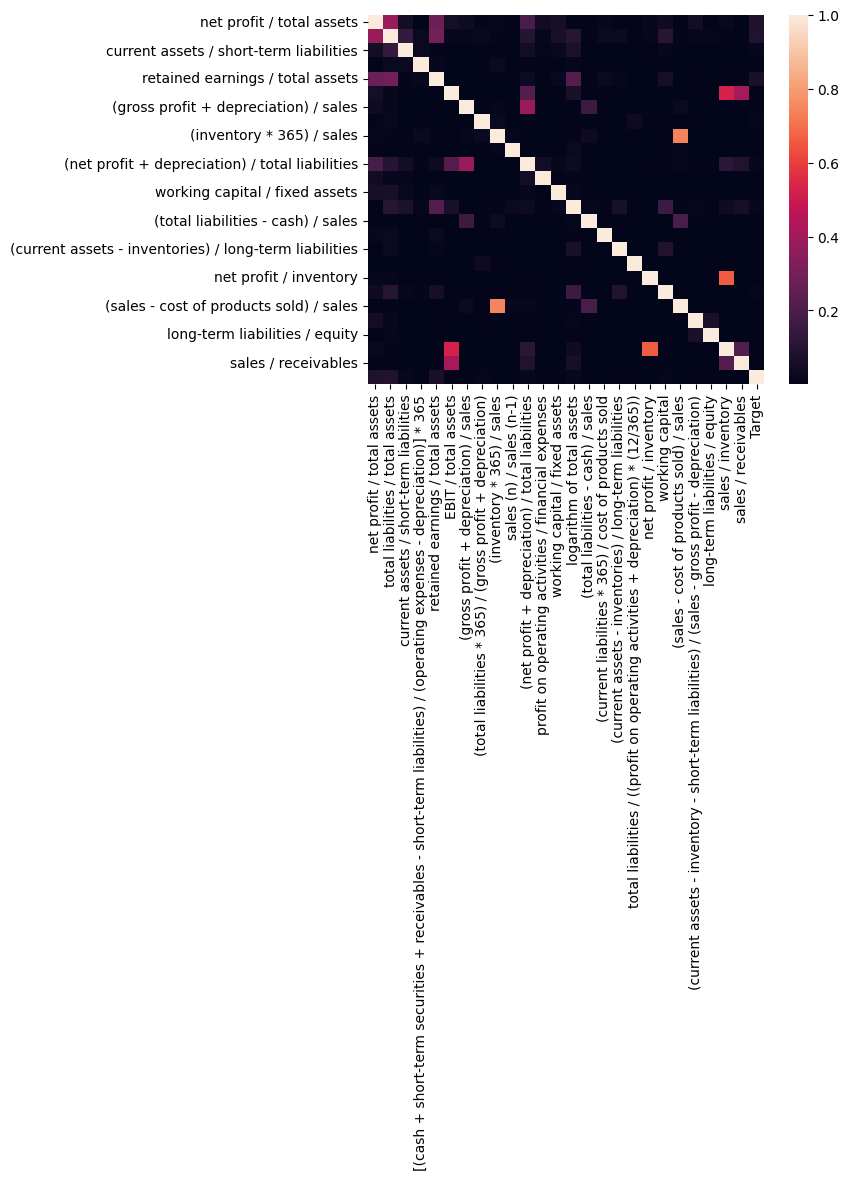

In [22]:
sns.heatmap(df.corr().abs());

### EDA

In [23]:
eda_df = df.copy()
eda_df['Target'] = eda_df['Target'].astype(int).astype(object)

In [24]:
temp_df = eda_df.groupby(['Target'])['net profit / total assets','working capital','EBIT / total assets','total liabilities / total assets'].mean().reset_index()
df2 = pd.melt(temp_df, id_vars=["Target"], var_name="Columns", value_name="Value")
df2['Target'] = df2['Target'].astype(int).astype(object)

In [25]:
fig = px.bar(df2, x="Columns", y="Value", color="Target", width=1200, height=600, color_discrete_sequence=['#66AA00','#E45756'], text_auto='.2')
fig.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=14,  # Set the font size here
        color="Black"
    )
)
fig.show()

In [26]:
fig = px.scatter(eda_df, x="logarithm of total assets", y="sales / inventory", color="Target",  color_discrete_sequence=['#66AA00','#E45756'], width=1000, height=600)
fig.update(layout_coloraxis_showscale=False)
fig.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=14,  # Set the font size here
        color="Black"
    )
)
fig.show()

In [27]:
fig = px.scatter(eda_df, x="working capital", y="sales / inventory", color="Target",  color_discrete_sequence=['#66AA00','#E45756'], width=1000, height=600)
fig.update(layout_coloraxis_showscale=False)
fig.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=14,  # Set the font size here
        color="Black"
    )
)
fig.show()

In [28]:
# fig = px.scatter(eda_df, x="logarithm of total assets", y="working capital",  color_discrete_sequence=['#66AA00','#E45756'], color="Target", width=1000, height=600)
# fig.update(layout_coloraxis_showscale=False)
# fig.update_layout(
#     font=dict(
#         family="Courier New, monospace",
#         size=14,  # Set the font size here
#         color="Black"
#     )
# )
# fig.show()

In [29]:
import plotly.express as px
fig = px.scatter(eda_df, x="logarithm of total assets", y="EBIT / total assets", color="Target",color_discrete_sequence=['#66AA00','#E45756'], width=1000, height=600)
fig.update(layout_coloraxis_showscale=False)
fig.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=14,  # Set the font size here
        color="Black"
    )
)
fig.show()

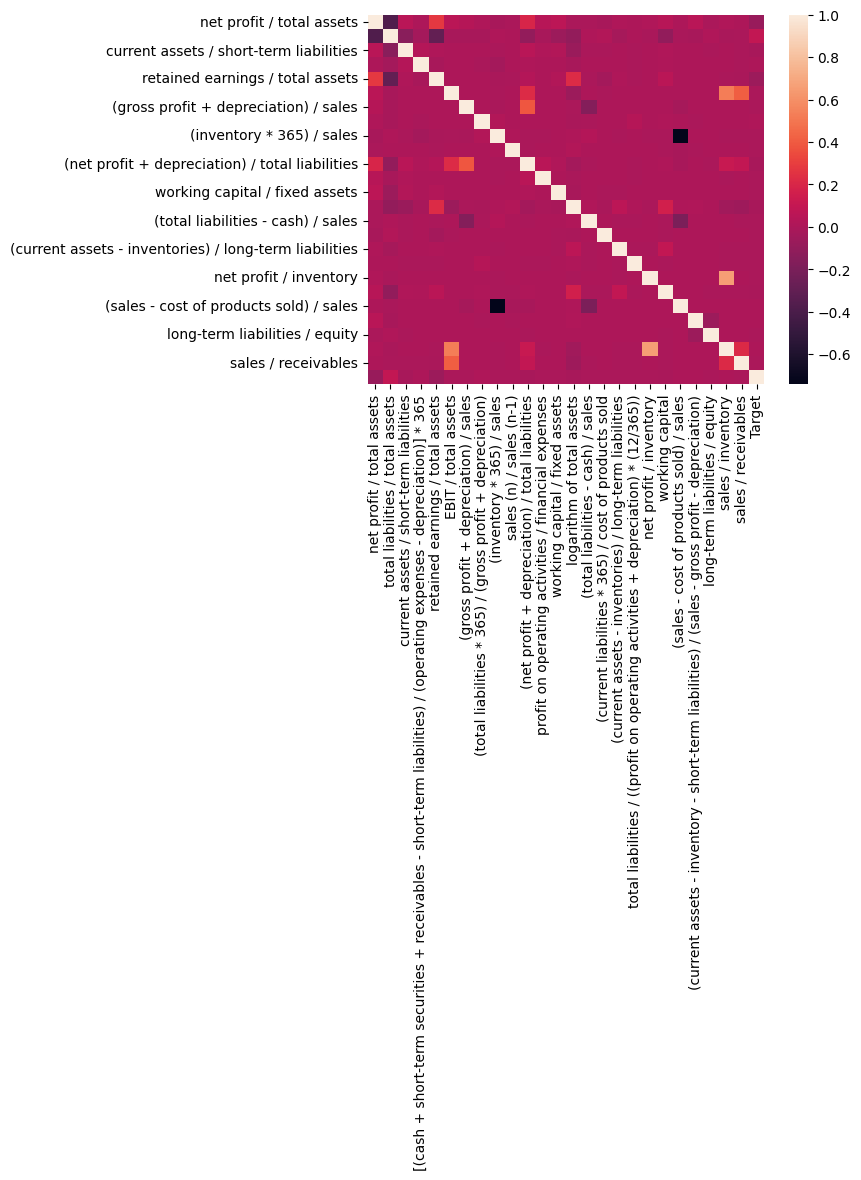

In [30]:
sns.heatmap(df.corr());

### Predictive Analysis

#### Oversampling

In [31]:
df = df.reset_index(drop=True)

In [32]:
y = df.Target
X = df.drop(['Target'],axis=1)

#### Modeling

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.70,random_state=1234)

In [34]:
df['Target'].value_counts()

0.0    9071
1.0     379
Name: Target, dtype: int64

In [35]:
import numpy as np
import pandas as pd
import random
from sklearn.neighbors import NearestNeighbors

def nearest_neighbour(X):
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def SMOTE(X):
    indices2 = nearest_neighbour(X)
    matrix=[]
    for i in range(23):
        for m in range(len(indices2)):
            t=x1[indices2[m]]
            newt=pd.DataFrame(t)
            matrix.append([])
            for j in range(len(newt.columns)):
                matrix[minority_shape*i+m].append(random.choice(newt[j]))
    return matrix

# 1. Getting the number of Minority Class Instances in Training Set
unique, counts = np.unique(y_train, return_counts=True)
minority_shape = dict(zip(unique, counts))[1]

# 2. Storing the minority class instances separately
x1 = np.ones((minority_shape, X_train.shape[1]))
x1=[X.iloc[i] for i, v in enumerate(y_train) if v==1.0]
x1=np.array(x1)

# Keeping the artificial instances and original instances together
sampled_instances = SMOTE(x1)
X_TrainSMOTE = np.concatenate((X_train,sampled_instances), axis = 0)
y_sampled_instances = np.ones(len(sampled_instances))
y_TrainSMOTE = np.concatenate((y_train,y_sampled_instances), axis=0)

In [36]:
SMOTE_train_df = pd.concat([pd.DataFrame(X_TrainSMOTE), pd.DataFrame(y_TrainSMOTE)],axis=1)

In [37]:
train_data = pd.concat([pd.DataFrame(X_TrainSMOTE), pd.DataFrame(y_TrainSMOTE)],axis=1)
train_data.columns = df.columns
# Creating dataframe with
test_data = pd.concat([X_test, y_test],axis=1)
test_data.columns = df.columns

In [38]:
X_train = np.array(X_TrainSMOTE)
y_train = np.array(y_TrainSMOTE)

In [39]:
pd.Series(y_train).value_counts()

1.0    6600
0.0    6340
dtype: int64

#### Logistic Regression

In [40]:
@dataclass
class LogisticRegression:
    learningRate:float
    maxIteration:int
    epsilon:float
    reg:str = 'noreg'
    gd:str = 'nogd'
    reg_par:int= 1
        
    def sigmoid(self, z):
        sig = 1/ (1+np.exp(-z))
        return sig
    
    def rank(self, X):
        v, s, u = np.linalg.svd(X)
        rank = sum([1 if i>0 else 0 for i in s])
        return rank

    def checkFullRank(self, X):
        rank = self.rank(X)
        if rank == min(X.shape):
            print('Its full rank.')
            self.fullRank = True
        else:
            self.fullRank = False
    
    def checkLowRank(self, X):
        if X.shape[1] > X.shape[0]:
            print("Its low rank.")
            self.lowRank = True
        else:
            self.lowRank = False
    
    def costFunction(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        loss = y*np.log(sig)+ (1-y)*np.log(1-sig)
        cost = -loss.sum()
        return cost

    def costDerivative(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        return np.dot(sig-y, X)
    
    def gradientDescent(self, X, y):
        errors = []
        prev_error = float(np.inf)
        
        for i in tqdm(range(self.maxIteration)):
            gradient = self.costDerivative(X, y)
            
            if self.reg == 'noreg':
                self.w = self.w - self.learningRate * gradient
            elif self.reg == 'l2':
                self.w = self.w - self.learningRate * (gradient+ self.reg_par*self.w)
            elif self.reg == 'l1':
                self.w = self.w - self.learningRate * (gradient+ self.reg_par*np.sign(self.w))
            
                
            current_error = self.costFunction(X, y)
            errors.append(current_error)
            if abs(current_error - prev_error) < self.epsilon:
                print('The model stopping learning')
                break
            prev_error = current_error
            
        self.plot_cost(errors)
    
    def stochasticGradientDescent(self, X, y, sample_fraction = 0.1):
        errors = []
        prev_error = float(np.inf)
        
        for i in tqdm(range(self.maxIteration)):
            ## Take sample of the datasets
            idx = np.random.randint(X.shape[0], size=int((X.shape[0])*sample_fraction))
            X_sample = X[idx,:]
            y_sample = y[idx]
            
            for i in range(len(X_sample)):
                gradient = self.costDerivative(X_sample[i], y_sample[i])
                
                if self.reg == 'noreg':
                    self.w = self.w - self.learningRate * gradient
                elif self.reg == 'l2':
                    self.w = self.w - self.learningRate * (gradient+ self.reg_par*self.w)
                elif self.reg == 'l1':
                    self.w = self.w - self.learningRate * (gradient+ self.reg_par*np.sign(self.w))
                
            current_error = self.costFunction(X_sample, y_sample)
            errors.append(current_error)
            
            if abs(current_error - prev_error) < self.epsilon:
                print('The model stopping learning')
                break
            prev_error = current_error
            
#         self.plot_cost(errors)
                
    def predict(self, X):
        sig = self.sigmoid(X.dot(self.w))
        return sig
    
    def fit(self, X_train, y_train):
        self.checkFullRank(X_train)
        self.checkLowRank(X_train)
        
        self.w = np.zeros(X_train.shape[1])
        
        if self.fullRank and not self.lowRank and len(X_train)<100000 and self.gd == 'nogd':
            self.w = self.costDerivative(X_train, y_train)
        elif self.gd == 'gd':
            self.gradientDescent(X_train, y_train)
        elif self.gd == 'sgd':
            self.stochasticGradientDescent(X_train, y_train)
        else:
            print('Please check parameter values!')
        
        
        y_train_hat = self.predict(X_train)
        pd.Series(y_train_hat).to_csv('temp.csv',index=False)
        recall, precision, f1_score = f1_score_metric(y_train, y_train_hat)
        
        accuracy = accuracy_rate(y_train, y_train_hat)
        roc_auc = ROC_AUC(y_train, y_train_hat)        
        
        
        print(f'The accuracy is {round(accuracy, 2)}.')
        print(f'The recall is {round(recall, 2)}.')
        print(f'The precision is {round(precision, 2)}.')
        print(f'The f1_score is {round(f1_score, 2)}.')
        print(f'The roc_auc is {round(roc_auc, 2)}.')
        
    
    def plot_cost(self,cost_sequence):
        
        s = np.array(cost_sequence)
        t = np.arange(s.size)
        
        fig, ax = plt.subplots()
        ax.plot(t,s)
        
        ax.set(xlabel = 'iterations', ylabel = 'cost' , title = 'cost trend')
        ax.grid()
        plt.legend(bbox_to_anchor=(1.05,1), loc=2,shadow=True)
        plt.show()
        

In [41]:
 # Accuracy score
def accuracy_rate(y, y_hat):
    y_hat = np.around(y_hat)
    correct = 0
    for i in range(len(y)):
        if y[i] == y_hat[i]:
            correct += 1
    return (correct / float(len(y))) * 100.0
    
def f1_score_metric(y, y_hat):
    y_hat = np.around(y_hat)
    y = (y==1)
    y_hat = (y_hat==1)

    recall = (y&y_hat).sum()/y.sum()
    precision = (y&y_hat).sum()/y_hat.sum()
    f1_score = 2*(precision*recall)/(precision+recall)

    return recall, precision, f1_score

def perf_metrics(y, y_hat,threshold):
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for i in range(len(y_hat)): 
        if(y_hat[i] >= threshold):
            if(y[i] == 1):
                tp += 1
            else:
                fp += 1
        elif(y_hat[i] < threshold):
            if(y[i] == 0):
                tn += 1
            else:
                fn += 1
    
    #We find the True positive rate and False positive rate based on the threshold
    tpr = tp/(tp+fn)
    fpr = fp/(tn+fp)
    return [fpr,tpr]

def ROC_AUC(y, y_hat):
    #Now we calculate FPR and TPR for different thresholds and get AUC and ROC
    thresholds = [0,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1]

    roc_points = []
    for threshold in thresholds:
        rates = perf_metrics(y, y_hat, threshold)
        roc_points.append(rates)

    fpr_array = []
    tpr_array = []
    for i in range(len(roc_points)-1):
        point1 = roc_points[i];
        point2 = roc_points[i+1]
        tpr_array.append([point1[0], point2[0]])
        fpr_array.append([point1[1], point2[1]])

    #We use Trapezoidal rule to calculate the area under the curve and approximating the intergral  
    auc = sum(np.trapz(tpr_array,fpr_array))+1

#     plt.plot(tpr_array,fpr_array, 'r', lw=2)
#     plt.plot([0, 1], [0, 1], 'k-', lw=2)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('AUC={}'.format(round(auc,3)))
#     plt.show()
    
    return auc

#### Logostic Regression

In [42]:
lr = LogisticRegression(learningRate=0.0001, maxIteration=1000, epsilon = 0.001, gd = 'nogd', reg='noreg')
lr.fit(X_train, y_train)

Its full rank.
The accuracy is 45.26.
The recall is 0.39.
The precision is 0.46.
The f1_score is 0.42.
The roc_auc is 0.53.


In [43]:
### Testing Data results
predictions = lr.predict(X_test)
predictions = np.array(predictions)
y_test = np.array(y_test)

In [44]:
accuracy = accuracy_rate(y_test, predictions)
print(f'The accuracy is {round(accuracy,2)}.')

recall, precision, f1_score = f1_score_metric(y_test, predictions)
print(f'The recall is {round(recall,2)}.')
print(f'The precision is {round(precision,2 )}.')
print(f'The f1_score is {round(f1_score,2 )}.')

roc_auc = ROC_AUC(y_test, predictions)        
print(f'The roc_auc is {round(roc_auc,2 )}.')

The accuracy is 53.09.
The recall is 0.51.
The precision is 0.04.
The f1_score is 0.07.
The roc_auc is 0.62.


#### Gradient Descent

Its full rank.


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1291.19it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


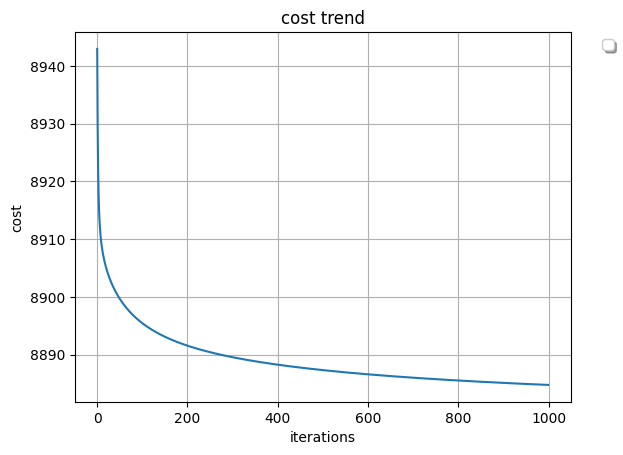

The accuracy is 54.71.
The recall is 0.75.
The precision is 0.54.
The f1_score is 0.63.
The roc_auc is 0.53.


In [45]:
lr = LogisticRegression(learningRate=0.0001, maxIteration=1000, epsilon = 0.001, gd = 'gd', reg='noreg')
lr.fit(X_train, y_train)

In [46]:
### Testing Data results
predictions = lr.predict(X_test)
predictions = np.array(predictions)
y_test = np.array(y_test)

In [47]:
accuracy = accuracy_rate(y_test, predictions)
print(f'The accuracy is {round(accuracy,2)}.')

recall, precision, f1_score = f1_score_metric(y_test, predictions)
print(f'The recall is {round(recall,2)}.')
print(f'The precision is {round(precision,2 )}.')
print(f'The f1_score is {round(f1_score,2 )}.')

roc_auc = ROC_AUC(y_test, predictions)        
print(f'The roc_auc is {round(roc_auc,2 )}.')

The accuracy is 33.3.
The recall is 0.62.
The precision is 0.03.
The f1_score is 0.06.
The roc_auc is 0.46.


#### Stochastic Gradient Descent

In [48]:
lr = LogisticRegression(learningRate=0.0001, maxIteration=1000, epsilon = 0.001, gd = 'sgd', reg='noreg')
lr.fit(X_train, y_train)

Its full rank.


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 52.98it/s]


The accuracy is 54.75.
The recall is 0.67.
The precision is 0.55.
The f1_score is 0.6.
The roc_auc is 0.54.


In [49]:
### Testing Data results
predictions = lr.predict(X_test)
predictions = np.array(predictions)
y_test = np.array(y_test)

In [50]:
accuracy = accuracy_rate(y_test, predictions)
print(f'The accuracy is {round(accuracy,2)}.')

recall, precision, f1_score = f1_score_metric(y_test, predictions)
print(f'The recall is {round(recall,2)}.')
print(f'The precision is {round(precision,2 )}.')
print(f'The f1_score is {round(f1_score,2 )}.')

roc_auc = ROC_AUC(y_test, predictions)        
print(f'The roc_auc is {round(roc_auc,2 )}.')

The accuracy is 41.16.
The recall is 0.57.
The precision is 0.04.
The f1_score is 0.07.
The roc_auc is 0.47.


#### Lasso Regularization

Its full rank.


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1341.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


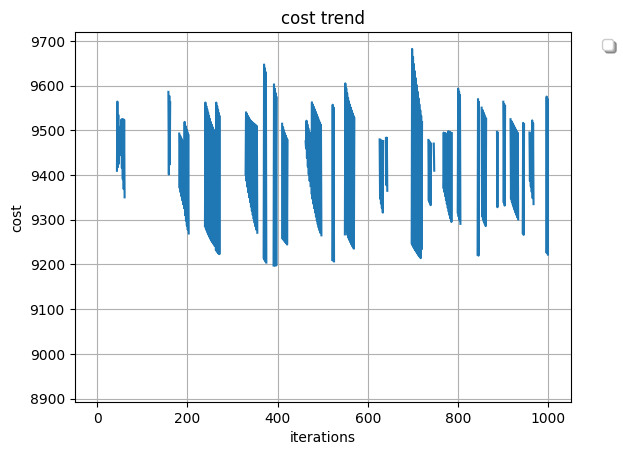

The accuracy is 48.46.
The recall is 0.5.
The precision is 0.49.
The f1_score is 0.5.
The roc_auc is 0.48.


In [51]:
lr = LogisticRegression(learningRate=0.0001, maxIteration=1000, epsilon = 0.001, gd = 'gd', reg='l1', reg_par=5000)
lr.fit(X_train, y_train)

In [52]:
### Testing Data results
predictions = lr.predict(X_test)
predictions = np.array(predictions)
y_test = np.array(y_test)

In [53]:
accuracy = accuracy_rate(y_test, predictions)
print(f'The accuracy is {round(accuracy,2)}.')

recall, precision, f1_score = f1_score_metric(y_test, predictions)
print(f'The recall is {round(recall,2)}.')
print(f'The precision is {round(precision,2 )}.')
print(f'The f1_score is {round(f1_score,2 )}.')

roc_auc = ROC_AUC(y_test, predictions)        
print(f'The roc_auc is {round(roc_auc,2 )}.')

The accuracy is 48.25.
The recall is 0.56.
The precision is 0.04.
The f1_score is 0.07.
The roc_auc is 0.54.


#### Ridge Regularization

Its full rank.


  8%|███                                     | 75/1000 [00:00<00:01, 818.81it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The model stopping learning


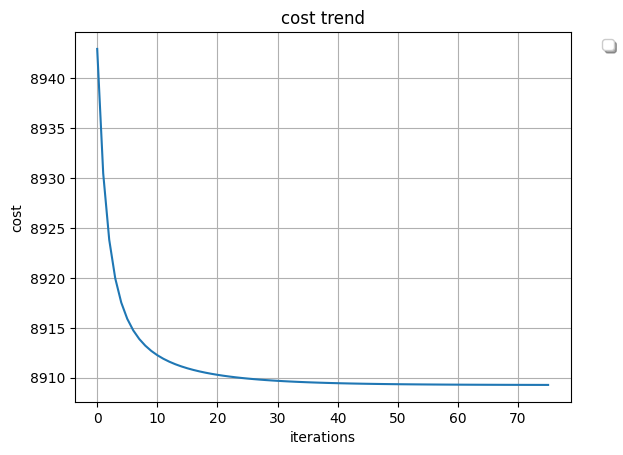

The accuracy is 55.0.
The recall is 0.63.
The precision is 0.55.
The f1_score is 0.59.
The roc_auc is 0.55.


In [54]:
lr = LogisticRegression(learningRate=0.0001, maxIteration=1000, epsilon = 0.001, gd = 'gd', reg='l2', reg_par=500)
lr.fit(X_train, y_train)

In [55]:
### Testing Data results
predictions = lr.predict(X_test)
predictions = np.array(predictions)
y_test = np.array(y_test)

In [56]:
accuracy = accuracy_rate(y_test, predictions)
print(f'The accuracy is {round(accuracy,2)}.')

recall, precision, f1_score = f1_score_metric(y_test, predictions)
print(f'The recall is {round(recall,2)}.')
print(f'The precision is {round(precision,2 )}.')
print(f'The f1_score is {round(f1_score,2 )}.')

roc_auc = ROC_AUC(y_test, predictions)        
print(f'The roc_auc is {round(roc_auc,2 )}.')

The accuracy is 45.04.
The recall is 0.52.
The precision is 0.03.
The f1_score is 0.06.
The roc_auc is 0.46.


#### Naive Bayes

In [57]:
# the categorical class names are changed to numberic data
# eg: yes and no encoded to 1 and 0

# Group the data rows under each class yes or
# no in dictionary eg: dict[yes] and dict[no]
def groupUnderClass(mydata):
    dict = {}
    for i in range(len(mydata)):
        if (mydata.iloc[i][-1] not in dict):
            dict[mydata.iloc[i][-1]] = []
        dict[mydata.iloc[i][-1]].append(mydata.iloc[i])
    return dict
 
# Calculating Mean
def mean(numbers):
    return sum(numbers) / float(len(numbers))
 
# Calculating Standard Deviation
def std_dev(numbers):
    avg = mean(numbers)
    variance = sum([pow(x - avg, 2) for x in numbers]) / float(len(numbers) - 1)
    return math.sqrt(variance)
 
def MeanAndStdDev(mydata):
    info = [(mean(attribute), std_dev(attribute)) for attribute in zip(*mydata)]
    # eg: list = [ [a, b, c], [m, n, o], [x, y, z]]
    # here mean of 1st attribute =(a + m+x), mean of 2nd attribute = (b + n+y)/3
    # delete summaries of last class
    del info[-1]
    return info
 
# find Mean and Standard Deviation under each class
def MeanAndStdDevForClass(mydata):
    info = {}
    dict = groupUnderClass(mydata)
    for classValue, instances in dict.items():
        info[classValue] = MeanAndStdDev(instances)
    return info

# Calculate Gaussian Probability Density Function
def calculateGaussianProbability(x, mean, stdev):
    expo = math.exp(-(math.pow(x - mean, 2) / (2 * math.pow(stdev, 2))))
    return (1 / (math.sqrt(2 * math.pi) * stdev)) * expo
 
# Calculate Class Probabilities
def calculateClassProbabilities(info, test):
    probabilities = {}
    for classValue, classSummaries in info.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, std_dev = classSummaries[i]
            x = test[i]
            probabilities[classValue] *= calculateGaussianProbability(x, mean, std_dev)
    return probabilities
 
# Make prediction - highest probability is the prediction
def predict(info, test):
    probabilities = calculateClassProbabilities(info, test)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.items():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel
 
# returns predictions for a set of examples
def getPredictions(info, test):
    predictions = []
    for i in range(len(test)):
        result = predict(info, test.iloc[i])
        predictions.append(result)
    return predictions
 
# prepare model
info = MeanAndStdDevForClass(train_data)


# train model
predictions = getPredictions(info, train_data)
accuracy = accuracy_rate(np.array(train_data['Target']), predictions)
print("Accuracy of your model is: ", accuracy)

recall, precision, f1_score = f1_score_metric(train_data['Target'], np.array(predictions))        
print(f'The recall is {recall}.')
print(f'The precision is {precision}.')
print(f'The f1_score is {f1_score}.')

roc_auc = ROC_AUC(y_train, predictions)
print(f'The roc_auc is {round(roc_auc,2 )}.')

Accuracy of your model is:  53.19938176197836
The recall is 0.975.
The precision is 0.5220671750770729.
The f1_score is 0.6800169079573074.
The roc_auc is 0.98.


In [58]:
# test model
predictions = getPredictions(info, test_data)
accuracy = accuracy_rate(np.array(test_data['Target']), predictions)
print("Accuracy of your model is: ", accuracy)


recall, precision, f1_score = f1_score_metric(test_data['Target'], np.array(predictions))        
print(f'The recall is {recall}.')
print(f'The precision is {precision}.')
print(f'The f1_score is {f1_score}.')

roc_auc = ROC_AUC(y_test, predictions)
print(f'The roc_auc is {round(roc_auc,2 )}.')

Accuracy of your model is:  9.594356261022927
The recall is 0.9134615384615384.
The precision is 0.03586258965647414.
The f1_score is 0.0690156193243734.
The roc_auc is 0.92.


#### SVM

In [59]:
@dataclass
class SVM:
    learning_rate:float = 0.01
    lambda_param:float = 0.01
    maxIteration:int = 100

    def fit(self, X, y):
        n_samples, n_features = X.shape

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in tqdm(range(self.maxIteration)):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.learning_rate * (self.lambda_param * self.w)
                else:
                    self.w -= self.learning_rate * (self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.learning_rate * y[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

In [60]:
svm = SVM()
svm.fit(X_train, y_train)

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.34it/s]


In [61]:
# train model
predictions = svm.predict(X_train)

accuracy = accuracy_rate(np.array(train_data['Target']), predictions)
print("Accuracy of your model is: ", accuracy)

recall, precision, f1_score = f1_score_metric(train_data['Target'], np.array(predictions))        
print(f'The recall is {recall}.')
print(f'The precision is {precision}.')
print(f'The f1_score is {f1_score}.')

roc_auc = ROC_AUC(y_train, predictions)
print(f'The roc_auc is {round(roc_auc,2 )}.')

Accuracy of your model is:  51.00463678516228
The recall is 1.0.
The precision is 0.5100463678516228.
The f1_score is 0.67553735926305.
The roc_auc is 1.0.


In [62]:
# test model
predictions = svm.predict(X_test)

accuracy = accuracy_rate(np.array(test_data['Target']), predictions)
print("Accuracy of your model is: ", accuracy)


recall, precision, f1_score = f1_score_metric(test_data['Target'], np.array(predictions))        
print(f'The recall is {recall}.')
print(f'The precision is {precision}.')
print(f'The f1_score is {f1_score}.')

roc_auc = ROC_AUC(y_test, predictions)
print(f'The roc_auc is {round(roc_auc,2 )}.')

Accuracy of your model is:  3.668430335097002
The recall is 1.0.
The precision is 0.03668430335097002.
The f1_score is 0.07077237155495066.
The roc_auc is 1.0.
